# End-to-end Learning with Autoencoders

In this notebook, you will learn how to implement an end-to-end communication system as an autoencoder [1].
The implemented system is shown in the figure below.
An additive white Gaussian noise (AWGN) channel is considered.
On the transmitter side, joint training of the constellation geometry and bit-labeling is performed, as in [2].
On the receiver side, a neural network-based demapper that computes log-likelihood ratios (LLRs) on the transmitted bits from the received samples is optimized.
The considered autoencoder is benchmarked against a quadrature amplitude modulation (QAM) with Gray labeling and the optimal AWGN demapper.

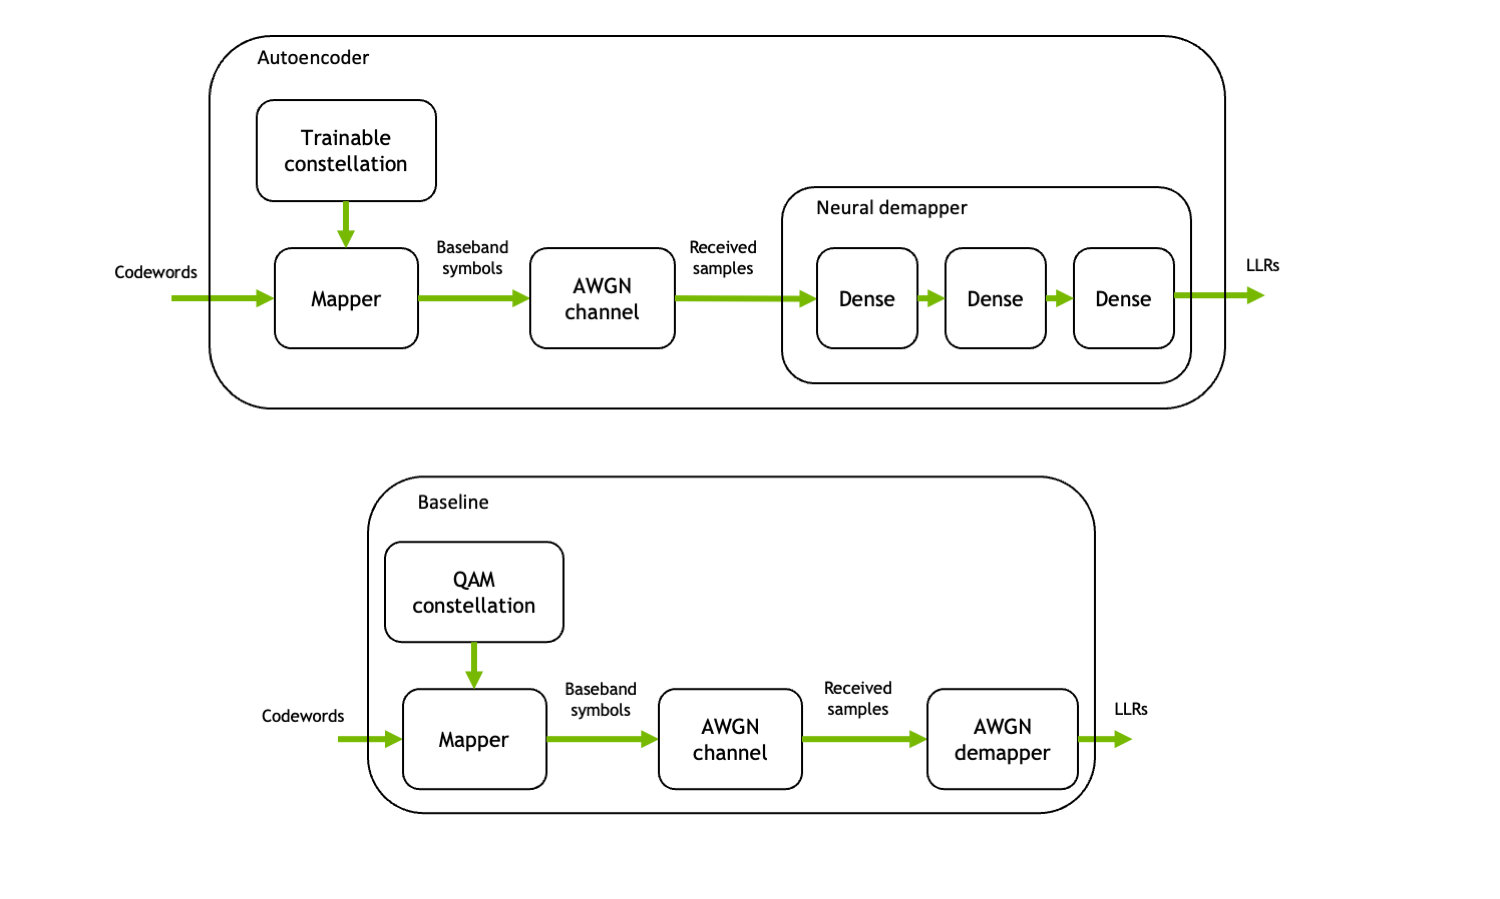


Two algorithms for training the autoencoder are implemented in this notebook:

* Conventional stochastic gradient descent (SGD) with backpropagation, which assumes a differentiable channel model and therefore optimizes the end-to-end system by backpropagating the gradients through the channel (see, e.g., [1]).
* The training algorithm from [3], which does not assume a differentiable channel model, and which trains the end-to-end system by alternating between conventional training of the receiver and reinforcement learning (RL)-based training of the transmitter. Compared to [3], an additional step of fine-tuning of the receiver is performed after alternating training.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/examples/Sionna_tutorial_part2.html).

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Demapper](#Neural-Demapper)
* [Trainable End-to-end System: Conventional Training](#Trainable-End-to-end-System:-Conventional-Training)
* [Trainable End-to-end System: RL-based Training](#Trainable-End-to-end-System:-RL-based-Training)
* [Evaluation](#Evaluation)
* [Visualizing the Learned Constellations](#Visualizing-the-Learned-Constellations)
* [References](#References)

## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [2]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
from sionna.channel import AWGN, FlatFadingChannel
from sionna.utils import BinarySource, ebnodb2no, log10, expand_to_rank, insert_dims, QAMSource
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mimo import lmmse_equalizer
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.utils import sim_ber

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [4]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

## Simulation Parameters <a class="anchor" id="Simulation-Parameters"></a>

In [22]:
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = -5.0
ebno_db_max = 25.0

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.5 # Coderate for the outer code
n = 750 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 10000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 7000
num_training_iterations_rl_finetuning = 3000
training_batch_size = tf.constant(64, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter

model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_conventional_training_rayleigh = "rayleigh_autoencoder_weights_conventional_training"
model_weights_path_conventional_training_CDL = "CDL_autoencoder_weights_conventional_training"

model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "autoencoder_results" # Location to save the results

sionna.config.xla_compat=True

In [6]:
print(num_symbols_per_codeword)
print(n, k)

125
750 750


## Neural Demapper <a class="anchor" id="Neural-Demapper"></a>

The neural network-based demapper shown in the figure above is made of three dense layers with ReLU activation.

The input of the demapper consists of a received sample $y \in \mathbb{C}$ and the noise power spectral density $N_0$ in log-10 scale to handle different orders of magnitude for the SNR.

As the neural network can only process real-valued inputs, these values are fed as a 3-dimensional vector

$$\left[ \mathcal{R}(y), \mathcal{I}(y), \log_{10}(N_0) \right]$$

where $\mathcal{R}(y)$ and $\mathcal{I}(y)$ refer to the real and imaginary component of $y$, respectively.

The output of the neural network-based demapper consists of LLRs on the `num_bits_per_symbol` bits mapped to a constellation point. Therefore, the last layer consists of ``num_bits_per_symbol`` units.

**Note**: The neural network-based demapper processes the received samples $y$ forming a block individually. The [neural receiver notebook](https://nvlabs.github.io/sionna/examples/Neural_Receiver.html) provides an example of a more advanced neural network-based receiver that jointly processes a resource grid of received symbols.

In [7]:
class NeuralDemapper(Layer):

    def __init__(self):
        super().__init__()

        self._dense_1 = Dense(128, 'relu')
        self._dense_2 = Dense(128, 'relu')
        self._dense_3 = Dense(num_bits_per_symbol, None) # The feature correspond to the LLRs for every bits carried by a symbol

    def call(self, inputs):
        y,no = inputs

        # Using log10 scale helps with the performance
        no_db = log10(no)

        # Stacking the real and imaginary components of the complex received samples
        # and the noise variance
        
        # no_db = tf.tile(no_db, [1, num_symbols_per_codeword]) # [batch size, num_symbols_per_codeword]
        z = tf.stack([tf.math.real(y),
                      tf.math.imag(y),
                      no_db], axis=2) # [batch size, num_symbols_per_codeword, 3]
        
        llr = self._dense_1(z)
        llr = self._dense_2(llr)
        llr = self._dense_3(llr) # [batch size, num_symbols_per_codeword, num_bits_per_symbol]

        return llr

## Trainable End-to-end System: Conventional Training <a class="anchor" id="Trainable-End-to-end-System:-Conventional-Training"></a>

The following cell defines an end-to-end communication system that transmits bits modulated using a trainable constellation over an AWGN channel.

The receiver uses the previously defined neural network-based demapper to compute LLRs on the transmitted (coded) bits.

As in [1], the constellation and neural network-based demapper are jointly trained through SGD and backpropagation using the binary cross entropy (BCE) as loss function.

Training on the BCE is known to be equivalent to maximizing an achievable information rate [2].

The following model can be instantiated either for training (`training = True`) or evaluation (`training = False`).

In the former case, the BCE is returned and no outer code is used to reduce computational complexity and as it does not impact the training of the constellation or demapper.

When setting `training` to `False`, an LDPC outer code from 5G NR is applied.

In [85]:
class E2ESystemConventionalTraining(Model):
    
    def __init__(self, training, channel):
        super().__init__()
        
        self._training = training
            
        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self._training:
            # num_bits_per_symbol is required for the interleaver 
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol) 
        # Trainable constellation
        constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)
        
        ################
        ## Channel
        ################
        if channel == "rayleigh":
            self.num_tx_ant = 1
            self.num_rx_ant = 1
            self._channel = FlatFadingChannel(self.num_tx_ant, self.num_rx_ant, add_awgn=True, return_channel=True)
        else:
            self._channel = AWGN()
        
        ################
        ## Receiver
        ################
        # We use the previously defined neural network for demapping
        self._demapper = NeuralDemapper()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
            
        #################
        # Loss function
        #################
        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        
        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)
        
        ################
        ## Transmitter
        ################
        # Outer coding is only performed if not training
        # if self._training:
        c = self._binary_source([batch_size, n])
        # else:
        #     b = self._binary_source([batch_size, k])
        #     c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        # rayleigh
        shape = tf.shape(x) # save before reshape
        x = tf.reshape(x, [-1, self.num_tx_ant])
        
        ################
        ## Channel
        ################
        # awgn
        # y = self._channel([x, no]) # [batch size, num_symbols_per_codeword]

         # rayleigh
        y,h = self._channel([x, no])
        no_expanded = tf.reshape(no, [batch_size, 1, 1])  # Reshape to [batch_size, 1, 1]
        s = tf.complex(no_expanded * tf.eye(1, 1), 0.0)
        # print(y.shape, h.shape, s.shape)
        x_hat, no_eff = lmmse_equalizer(y, h, s)
        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)
        
        ################
        ## Receiver
        ################
        # llr = self._demapper([y, no])
        
        # rayleigh
        llr = self._demapper([x_hat, no_eff])

        llr = tf.reshape(llr, [batch_size, n])
        
        # If training, outer decoding is not performed and the BCE is returned
        if self._training:
            loss = self._bce(c, llr)
            return loss
        else:
            # Outer decoding
            # b_hat = self._decoder(llr)
            # return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation
    
            # without encoding
            probabilities = tf.nn.sigmoid(llr)
            b_hat = tf.cast(probabilities > 0.5, dtype=tf.float32) # 0.5-1 is False=bit 0; 0-0.5 is True=bit 1
            return c,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [13]:
binary_source = BinarySource()
# Trainable constellation
constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
mapper = Mapper(constellation=constellation)

c = binary_source([64, n])
x = mapper(c) # x [batch size, num_symbols_per_codeword]
print(x.shape)
shape = tf.shape(x) # save before reshape
x = tf.reshape(x, [-1, 1])

print("x:", x.shape)

channel = FlatFadingChannel(1, 1, add_awgn=True, return_channel=True)
# no = 0.2 # Noise variance of the channel

# ebno_db = np.arange(ebno_db_min, # Min SNR for evaluation
#                      ebno_db_max, # Max SNR for evaluation
#                      0.5) # Step
ebno_db = tf.random.uniform(shape=[8000], minval=ebno_db_min, maxval=ebno_db_max)

print("ebno:", ebno_db.shape)
if len(ebno_db.shape) == 0:
    ebno_db = tf.fill([batch_size], ebno_db)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
# no *= np.sqrt(num_rx_ant)
no = expand_to_rank(no, 2)
print("no:", no.shape)

# y and h are the channel output and channel realizations, respectively.
y,h = channel([x, no])
no_expanded = tf.reshape(no, [8000, 1, 1])  # Reshape to [batch_size, 1, 1]
s = no_expanded * tf.eye(1, 1, batch_shape=[8000])
s = tf.complex(s, 0.0)

print(y.shape, h.shape, s.shape)

x_hat, no_eff = lmmse_equalizer(y, h, s)
x_hat = tf.reshape(x_hat, shape)
no_eff = tf.reshape(no_eff, shape)

(64, 125)
x: (8000, 1)
ebno: (8000,)
no: (8000, 1)
(8000, 1) (8000, 1, 1) (8000, 1, 1)


A simple training loop is defined in the next cell, which performs `num_training_iterations_conventional` training iterations of SGD. Training is done over a range of SNR, by randomly sampling a batch of SNR values at each iteration.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/examples/Sionna_tutorial_part2.html).

In [16]:
def conventional_training(model):
    # Optimizer used to apply gradients
    optimizer = tf.keras.optimizers.Adam()
    for i in range(num_training_iterations_conventional):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[training_batch_size*num_symbols_per_codeword], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            loss = model(training_batch_size, ebno_db) # The model is assumed to return the BMD rate
            
        # Computing and applying gradients        
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        
        # Printing periodically the progress
        if i % 10 == 0:
            print('Iteration {}/{}  BCE: {:.4f}'.format(i, num_training_iterations_conventional, loss.numpy()), end='\r')

The next cell defines a utility function for saving the weights using [pickle](https://docs.python.org/3/library/pickle.html).

In [14]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

In the next cell, an instance of the model defined previously is instantiated and trained.

In [15]:
# Fix the seed for reproducible trainings
tf.random.set_seed(1)
# Instantiate and train the end-to-end system
model = E2ESystemConventionalTraining(training=True, channel="awgn")
conventional_training(model)
# Save weights
save_weights(model, model_weights_path_conventional_training)

NameError: name 'conventional_training' is not defined

In [17]:
# Fix the seed for reproducible trainings
tf.random.set_seed(1)
# Instantiate and train the end-to-end system
model = E2ESystemConventionalTraining(training=True, channel="rayleigh")
conventional_training(model)
# Save weights
save_weights(model, model_weights_path_conventional_training_rayleigh)

I0000 00:00:1716462572.366309   55990 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## Evaluation <a class="anchor" id="Evaluation"></a>

The following cell implements a baseline which uses QAM with Gray labeling and conventional demapping for AWGN channel.

In [74]:
class Baseline(Model):
    def __init__(self, channel):
        super().__init__()
        
        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        constellation = Constellation("qam", num_bits_per_symbol, trainable=False)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)
        
        ################
        ## Channel
        ################
        if channel == "rayleigh":
            self.num_tx_ant = 1
            self.num_rx_ant = 1
            self._channel = FlatFadingChannel(self.num_tx_ant, self.num_rx_ant, add_awgn=True, return_channel=True)
        else:
            self._channel = AWGN()
        
        ################
        ## Receiver
        ################
        self._demapper = Demapper("app", constellation=constellation)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
    
    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db, perturbation_variance=tf.constant(0.0, tf.float32)):
        
        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)
        
        ################
        ## Transmitter
        ################
        # b = self._binary_source([batch_size, k])
        c = self._binary_source([batch_size, n])
        # c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        # rayleigh
        shape = tf.shape(x) # save before reshape
        x = tf.reshape(x, [-1, self.num_tx_ant])
        
        ################
        ## Channel
        ################
        # AWGN
        # y = self._channel([x, no]) # [batch size, num_symbols_per_codeword]
        
        # rayleigh
        y,h = self._channel([x, no])
        no_expanded = tf.reshape(no, [-1, 1, 1])  # Reshape to [batch_size, 1, 1]
        s = tf.complex(no_expanded * tf.eye(1, 1), 0.0)
        # print(y.shape, h.shape, s.shape)
        x_hat, no_eff = lmmse_equalizer(y, h, s)
        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)
        
        ################
        ## Receiver
        ################
        # awgn
        # llr = self._demapper([y, no]) 

        # rayleigh
        llr = self._demapper([x_hat, no_eff])
        print(c.shape, llr.shape)
        
        # Outer decoding
        # b_hat = self._decoder(llr)
        # return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

        # without encoding
        probabilities = tf.nn.sigmoid(llr)
        b_hat = tf.cast(probabilities > 0.5, dtype=tf.float32) # 0.5-1 is False=bit 0; 0-0.5 is True=bit 1
        return c,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [63]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

In [20]:
# Utility function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

# Dictionnary storing the results
BLER = {}
BER = {}

The next cell evaluate the baseline and the two autoencoder-based communication systems, trained with different method.
The results are stored in the dictionary ``BLER``.

In [ ]:
model_baseline_awgn = Baseline(channel="awgn")
ber,bler = sim_ber(model_baseline_awgn, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
BLER['baseline-awgn'] = bler.numpy()
BER['baseline-awgn'] = ber.numpy()

model_conventional = E2ESystemConventionalTraining(training=False, channel="awgn")
load_weights(model_conventional, model_weights_path_conventional_training)
ber,bler = sim_ber(model_conventional, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
BLER['autoencoder-conv'] = bler.numpy()
BER['autoencoder-conv'] = ber.numpy()

with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BLER, BER), f)

In [79]:
with open(results_filename, 'rb') as file:
        ebno_dbs, BLER, BER = pickle.load(file)
model_baseline_rayleigh = Baseline(channel="rayleigh")
ber,bler = sim_ber(model_baseline_rayleigh, ebno_dbs, batch_size=1, num_target_block_errors=1000, max_mc_iter=1000)
BLER['baseline-rayleigh'] = bler.numpy()
BER['baseline-rayleigh'] = ber.numpy()

(None, 750) (None, 750)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.7739e-01 | 1.0000e+00 |      283043 |      750000 |         1000 |        1000 |        10.8 |reached target block errors
     -4.5 | 3.7103e-01 | 1.0000e+00 |      278274 |      750000 |         1000 |        1000 |         9.9 |reached target block errors
     -4.0 | 3.6367e-01 | 1.0000e+00 |      272752 |      750000 |         1000 |        1000 |         9.9 |reached target block errors
     -3.5 | 3.5570e-01 | 1.0000e+00 |      266778 |      750000 |         1000 |        1000 |         9.8 |reached target block errors
     -3.0 | 3.4838e-01 | 1.0000e+00 |      261283 |      750000 |         1000 |        1000 |         9.9 |reached target block errors
     -2.5 | 3.4041e-01 | 1.0000e+00 |    

InvalidArgumentError: Exception encountered when calling layer 'e2e_system_conventional_training_2' (type E2ESystemConventionalTraining).

Input to reshape is a tensor with 1 values, but the requested shape has 125

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
File "/home/ubuntu/miniconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
File "/home/ubuntu/miniconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
File "/home/ubuntu/miniconda3/lib/python3.11/asyncio/events.py", line 80, in _run
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
File "/tmp/ipykernel_55990/3446982468.py", line 9, in <module>
File "/tmp/ipykernel_55990/2730809063.py", line 3, in load_weights
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__
File "/home/ubuntu/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
File "/tmp/ipykernel_55990/611945968.py", line 81, in call

	 [[{{node Reshape_2}}]]
	tf2xla conversion failed while converting __inference_call_10476632[_XlaMustCompile=true,config_proto=3175580994766145631,executor_type=11160318154034397263]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions. [Op:__inference_call_10476632]

Call arguments received by layer 'e2e_system_conventional_training_2' (type E2ESystemConventionalTraining):
  • batch_size=tf.Tensor(shape=(), dtype=int32)
  • ebno_db=tf.Tensor(shape=(), dtype=float32)

In [86]:
model_conventional = E2ESystemConventionalTraining(training=False, channel="rayleigh")
load_weights(model_conventional, model_weights_path_conventional_training_rayleigh)
ber,bler = sim_ber(model_conventional, ebno_dbs, batch_size=1, num_target_block_errors=1000, max_mc_iter=1000)
BLER['autoencoder-conv-rayleigh'] = bler.numpy()
BER['autoencoder-conv-rayleigh'] = ber.numpy()

with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BLER, BER), f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.7801e-01 | 1.0000e+00 |      283511 |      750000 |         1000 |        1000 |         9.7 |reached target block errors
     -4.5 | 3.7102e-01 | 1.0000e+00 |      278262 |      750000 |         1000 |        1000 |         9.7 |reached target block errors
     -4.0 | 3.6315e-01 | 1.0000e+00 |      272365 |      750000 |         1000 |        1000 |         9.6 |reached target block errors
     -3.5 | 3.5675e-01 | 1.0000e+00 |      267559 |      750000 |         1000 |        1000 |         9.7 |reached target block errors
     -3.0 | 3.5019e-01 | 1.0000e+00 |      262645 |      750000 |         1000 |        1000 |         9.7 |reached target block errors
     -2.5 | 3.4119e-01 | 1.0000e+00 |      255892 |      750000 |

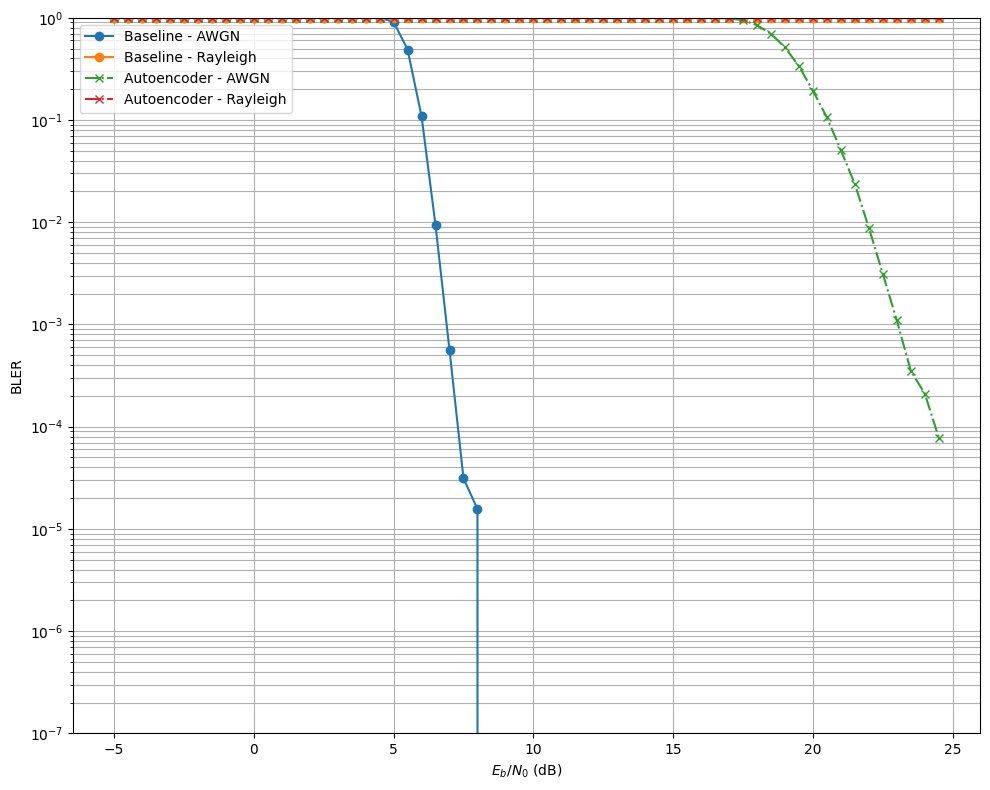

In [87]:
with open(results_filename, 'rb') as file:
        ebno_dbs, BLER, BER = pickle.load(file)
    
plt.figure(figsize=(10,8))
# Baseline - Perfect CSI
plt.semilogy(ebno_dbs, BLER['baseline-awgn'], 'o-', c=f'C0', label=f'Baseline - AWGN')    
plt.semilogy(ebno_dbs, BLER['baseline-rayleigh'], 'o-', c=f'C1', label=f'Baseline - Rayleigh')    
# Autoencoder - conventional training
plt.semilogy(ebno_dbs, BLER['autoencoder-conv'], 'x-.', c=f'C2', label=f'Autoencoder - AWGN')
# Autoencoder - conventional training rayleigh
plt.semilogy(ebno_dbs, BLER['autoencoder-conv-rayleigh'], 'x-.', c=f'C3', label=f'Autoencoder - Rayleigh')

# Autoencoder - RL-based training
# plt.semilogy(ebno_dbs, BLER['autoencoder-rl'], 'o-.', c=f'C3', label=f'Autoencoder - RL-based training')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-7, 1.0))
plt.legend()
plt.tight_layout()

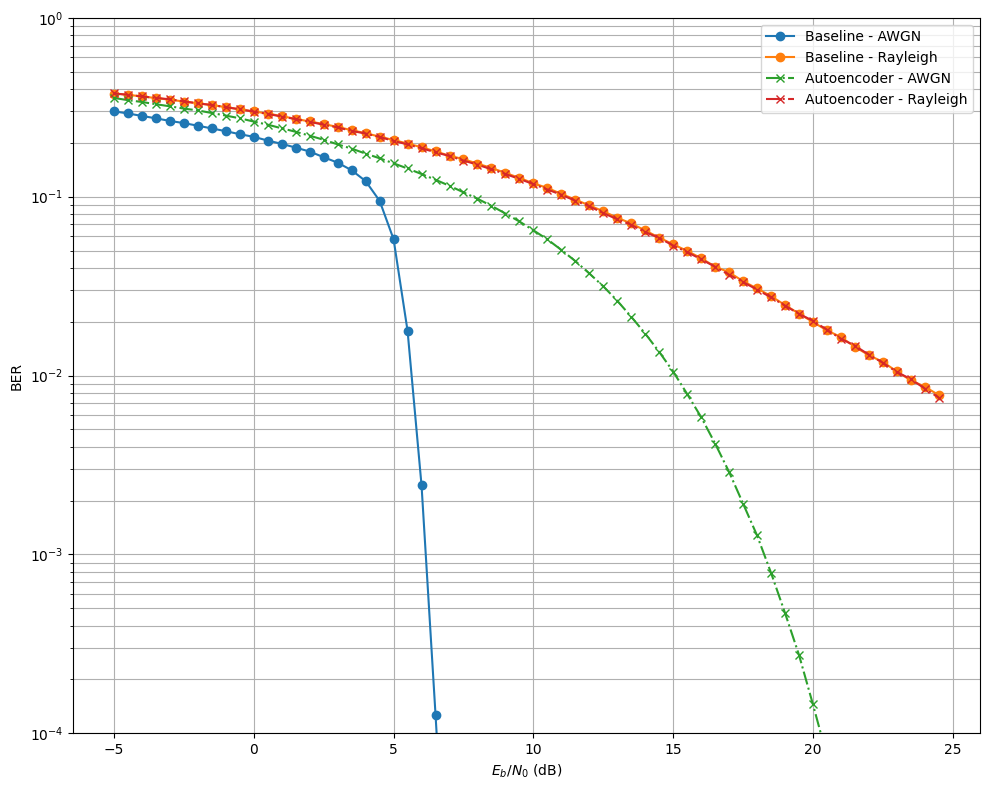

In [89]:
plt.figure(figsize=(10,8))
# Baseline - Perfect CSI
plt.semilogy(ebno_dbs, BER['baseline-awgn'], 'o-', c=f'C0', label=f'Baseline - AWGN')    
plt.semilogy(ebno_dbs, BER['baseline-rayleigh'], 'o-', c=f'C1', label=f'Baseline - Rayleigh')   
# Autoencoder - conventional training
plt.semilogy(ebno_dbs, BER['autoencoder-conv'], 'x-.', c=f'C2', label=f'Autoencoder - AWGN')
# Autoencoder - conventional training rayleigh
plt.semilogy(ebno_dbs, BER['autoencoder-conv-rayleigh'], 'x-.', c=f'C3', label=f'Autoencoder - Rayleigh')

# Autoencoder - RL-based training
# plt.semilogy(ebno_dbs, BLER['autoencoder-rl'], 'o-.', c=f'C3', label=f'Autoencoder - RL-based training')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()

## Visualizing the Learned Constellations <a class="anchor" id="Visualizing-the-Learned-Constellations"></a>

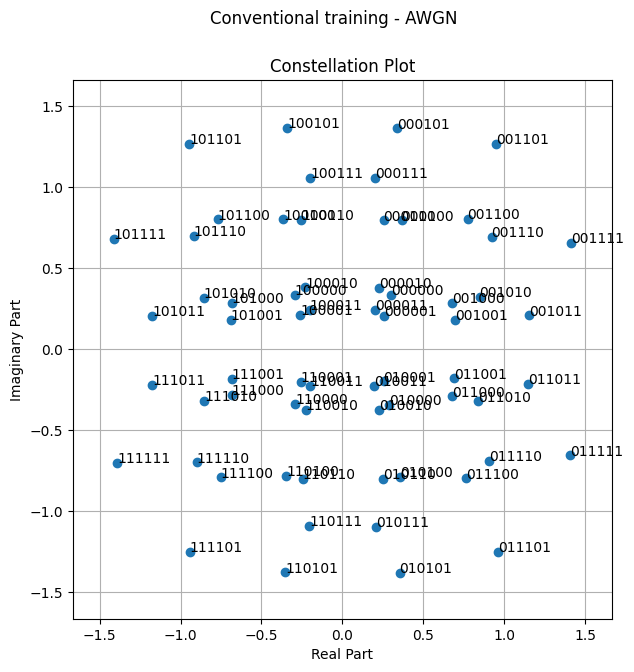

In [19]:
# AWGN
model_conventional = E2ESystemConventionalTraining(training=True, channel="awgn")
load_weights(model_conventional, model_weights_path_conventional_training)
fig = model_conventional.constellation.show()
fig.suptitle('Conventional training - AWGN');

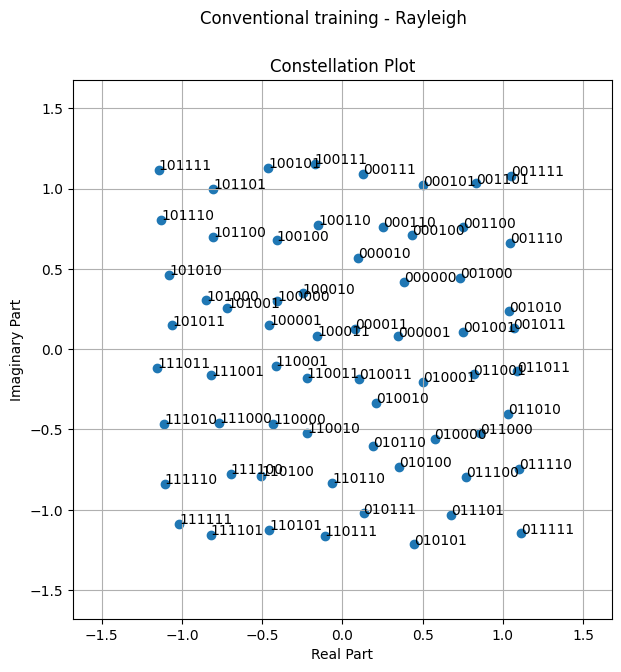

In [20]:
# Rayleigh
model_conventional = E2ESystemConventionalTraining(training=True, channel="rayleigh")
load_weights(model_conventional, model_weights_path_conventional_training_rayleigh)
fig = model_conventional.constellation.show()
fig.suptitle('Conventional training - Rayleigh');

In [ ]:
model_rl = E2ESystemRLTraining(training=False)
load_weights(model_rl, model_weights_path_rl_training)
fig = model_rl.constellation.show()
fig.suptitle('RL-based training');

## References <a class="anchor" id="References"></a>

[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.

[2] S. Cammerer, F. Ait Aoudia, S. Dörner, M. Stark, J. Hoydis and S. ten Brink, "Trainable Communication Systems: Concepts and Prototype," in IEEE Transactions on Communications, vol. 68, no. 9, pp. 5489-5503, Sept. 2020, doi: 10.1109/TCOMM.2020.3002915.

[3] F. Ait Aoudia and J. Hoydis, "Model-Free Training of End-to-End Communication Systems," in IEEE Journal on Selected Areas in Communications, vol. 37, no. 11, pp. 2503-2516, Nov. 2019, doi: 10.1109/JSAC.2019.2933891.